In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchviz
!pip install torchview
!pip install timm

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=e4af4e0f2d0366cff9e92ce7ca30572f64aeb10d2e9aaa06dbee3dddc7644c79
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
from torch import Tensor
from typing import Type
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchview import draw_graph
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import Accuracy
import copy
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from PIL import Image
torch.manual_seed(42)

In [4]:
# x_train = []
# base_path = '/kaggle/input/task2-png/DATA/Shashank/Task2Uncompressed/'
# for i in os.listdir(base_path):
# #     path = os.path.join(base_path,i)
# #     with Image.open(path) as img:
# #         img = np.array(img).astype('float32')
# #     x_train.append(img)
#     print(i)
#     break
    
import os
import numpy as np
from PIL import Image
import multiprocessing

def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        with Image.open(img_path) as img:
            img = np.array(img)
            images.append(img)
    return images

def load_images_multiprocess(paths):
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        images = pool.map(load_images, paths)
    return images

path_1 = '/kaggle/input/task2-png/DATA/Shashank/Task2Uncompressed/0/'
path_2 = '/kaggle/input/task2-png/DATA/Shashank/Task2Uncompressed/1/'

x_1, x_2 = load_images_multiprocess([path_1, path_2])

y_1 = np.ones(len(x_1))
y_2 = np.zeros(len(x_2))

x = np.concatenate([x_1, x_2], axis=0)
y = np.concatenate([y_1, y_2], axis=0)

del x_1, x_2, y_1, y_2


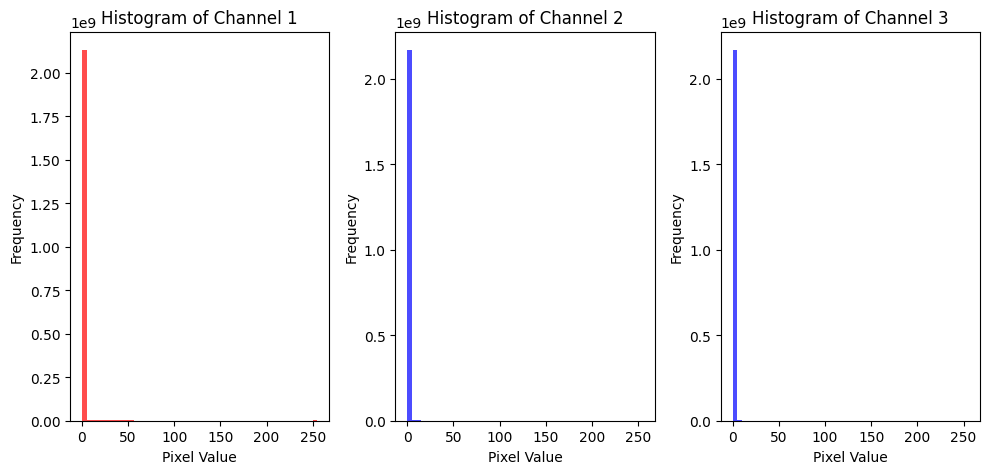

In [5]:
flattened_image = x.reshape((-1, 3))
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.hist(flattened_image[:, 0], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Channel 1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(flattened_image[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(flattened_image[:, 2], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 3')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
import torch
import math
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        
        x = self.conv(x)
        
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super(ChannelGate, self).__init__()
        
        # Number of input channels to image
        self.gate_channels = gate_channels
        
        #MLP layer
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )

    def forward(self, x):
        
        #Avg_pool
        avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_avg = self.mlp( avg_pool )

        #max_pool
        max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_max = self.mlp( max_pool )

        #Element wise sum
        channel_att_sum = channel_att_max + channel_att_avg

        #scaling output of channel attention to match dimensions with input
        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        return x * scale


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        
    def forward(self, x):
        
        # Applying Average Pooling and Maxpooling layer and concatenating
        x_compress = self.compress(x)
        
        # Applying Convolution operation on concatenated inputs
        x_out = self.spatial(x_compress)
        
        # Applying Sigmoid to attention mask
        scale = F.sigmoid(x_out) # broadcasting
        
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=1, no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        self.no_spatial=no_spatial
        
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [7]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding='same')
        self.bn_1 = nn.BatchNorm2d(out_channels)
        self.conv_2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding='same')
        self.bn_2 = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

class VGG_12(nn.Module):
    def __init__(self, BasicBlock, in_channels, out_channels, CBAM):
        super(VGG_12, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block_1 = self.__make_layer(BasicBlock, change = 'yes')
        self.cbam_1 = self.channel_block_attention(CBAM)
        self.block_2 = self.__make_layer(BasicBlock, change = 'yes')
        self.cbam_2 = self.channel_block_attention(CBAM)
        self.block_3 = self.__make_layer(BasicBlock, change = 'yes')
        self.cbam_3 = self.channel_block_attention(CBAM)
        self.block_4 = self.__make_layer(BasicBlock, change = 'NO')
        self.cbam_4 = self.channel_block_attention(CBAM)
        self.block_5 = self.__make_layer(BasicBlock, change = 'NO')
        self.fc_1 = nn.Linear(in_features=128, out_features=64)  # Adjust in_features according to the output shape after blocks
#         self.fc_2 = nn.Linear(in_features=512, out_features=64)
        self.fc_3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        self.avg_pool = nn.AvgPool2d(kernel_size = 3)
        
    def __make_layer(self, block, change):
        op =  block(in_channels=self.in_channels, out_channels=self.out_channels)
        self.in_channels = self.out_channels
        if change == 'yes':
            self.out_channels = self.out_channels*2
        return op
    
    def channel_block_attention(self, cbam):
        return cbam(self.in_channels)
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.cbam_1(x)
#         x = self.relu(x)
        
        x = self.block_2(x)
        x = self.cbam_2(x)
#         x = self.relu(x)
        
        x = self.block_3(x)
        x = self.cbam_3(x)
#         x = self.relu(x)
        
        x = self.block_4(x)
        x = self.cbam_4(x)
#         x = self.relu(x)
        
        x = self.block_5(x)
#         x = self.relu(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_1(x)
#         x = self.dropout(x)
        x = self.relu(x)
        
        x = self.fc_3(x)
        x = self.sigmoid(x)
        return x

# class VGG12(nn.Module):
#     def __init__(self, num_classes=10):
#         super(VGG12, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU())
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(), 
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU())
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU())
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer8 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.layer9 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.layer10 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.layer11 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.layer12 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU())
#         self.layer13 = nn.Sequential(
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 2, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(512, 64),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(64, 1),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))
#         self.avg_pool = nn.AvgPool2d(kernel_size = 7, stride = 1)
#         self.sigmoid = nn.Sigmoid()
        
#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = self.layer6(out)
#         out = self.layer7(out)
#         out = self.layer8(out)
#         out = self.layer9(out)
#         out = self.layer10(out)
#         out = self.avg_pool(out)
# #         out = self.layer11(out)
# #         out = self.layer12(out)
# #         out = self.layer13(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.sigmoid(out)
# #         out = self.fc2(out)
        return out

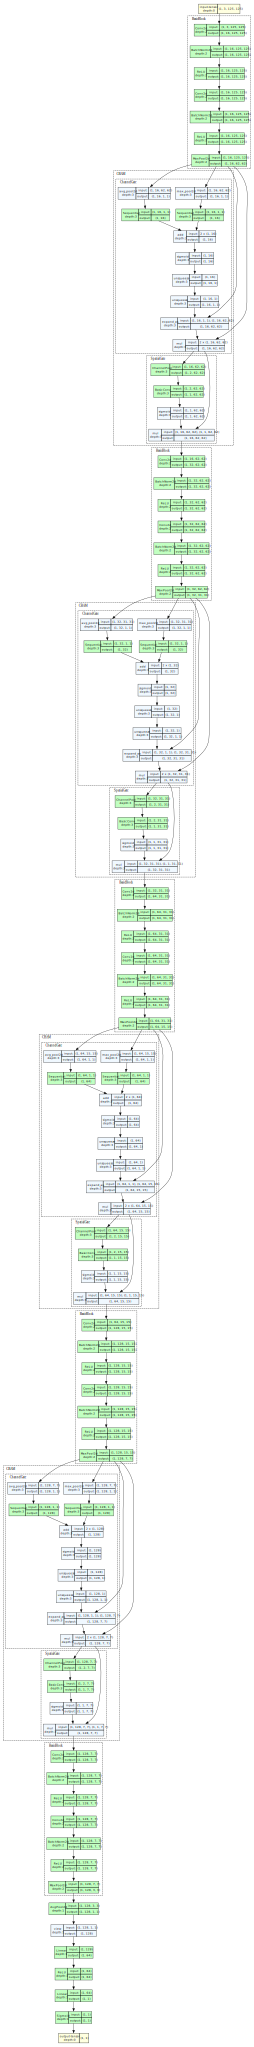

In [8]:
model = VGG_12(BasicBlock, 3, 16, CBAM)
model_graph = draw_graph(model, input_size=(1,3,125,125), expand_nested=True)
model_graph.visual_graph

In [9]:
import gc
gc.collect()

17978

In [10]:
class CustomDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.x[idx]
        label = self.y[idx]
        label = torch.tensor(label).float().unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        
        sample = {'image':img, 'labels' : label}
        
        return sample
            
# Define transformations to apply to the images
transform = transforms.Compose([
    # torchvision.transforms.ToPILImage(),
    # transforms.RandomHorizontalFlip(),   # Randomly flip the image horizontally
    # transforms.RandomVerticalFlip(),     # Randomly flip the image vertically
    # transforms.RandomRotation(10),       # Randomly rotate the image by up to 10 degrees
    transforms.ToTensor()                # Convert PIL Image to tensor
])


# Create the ImageFolder dataset
dataset = CustomDataset(x, y, transform = transform)

sample = dataset.__getitem__(0)
print(sample['image'].shape)
print(sample['labels'])

torch.Size([3, 125, 125])
tensor([1.])


In [11]:
DEVICE = torch.device("cuda")

In [12]:
del model
import gc
import ctypes
libc = ctypes.CDLL("libc.so.6")
gc.collect()
libc.malloc_trim(0)
torch.cuda.empty_cache()

In [13]:
def model_train(fold, model, epochs, train_dataloader, test_dataloader):
    
    # --------------------Loss function and optimizer--------------------
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    # -------------------------------------------------------------------

    best_acc = -np.inf  # Init to negative infinity
    best_weights = None
    accuracy = Accuracy(task = 'binary').to(DEVICE)
 
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        train_pred = []
        val_pred = []
        
        # --------------------Training Loop--------------------
        model.train()
        for batch in tqdm(train_dataloader):
            images, labels = batch['image'], batch['labels']
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_pred.append(loss.item())

            # Calculate training accuracy
            train_acc = accuracy(outputs, labels)
            train_accuracies.append(train_acc.item())

        train_loss = np.mean(train_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # --------------------Validation Loop--------------------
        model.eval()
        with torch.no_grad():
            for val_batch in tqdm(test_dataloader):
                val_images, val_labels = val_batch['image'], val_batch['labels']
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_pred.append(val_loss.item())

                # Calculate validation accuracy
                val_acc = accuracy(val_outputs, val_labels)
                val_accuracies.append(val_acc.item())

        val_loss = np.mean(val_pred)
        # -------------------------------------------------------
        # -------------------------------------------------------
        
        # Print and store losses and accuracies
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {np.mean(train_accuracies):.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {np.mean(val_accuracies):.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        with open('vgg_loss.txt', 'a') as f:  # Open file in append mode
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}\n')
            
        # Save best model
        if max(train_accuracies) > best_acc:
            best_acc = max(train_accuracies)
            best_weights = copy.deepcopy(model.state_dict())
    
    # Save the best model
    torch.save(best_weights, f'./best_model_{fold}.pth')

    # Plot training and validation losses
    return train_losses, val_losses, train_accuracies, val_accuracies


In [14]:
# del model
import gc
import ctypes
libc = ctypes.CDLL("libc.so.6")
gc.collect()
libc.malloc_trim(0)
torch.cuda.empty_cache()

In [15]:
k_folds = 5
batch_size = 256

# -------------------------------------------------------
#                   Training KFold Starts
# -------------------------------------------------------
kf = KFold(n_splits=k_folds, shuffle=True)

trn_fold_loss = []
val_fold_loss = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    
    print(f'*** Fold {fold}***')
    print('Training Started.....')
    
    train_loader = DataLoader(dataset=dataset,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(train_idx))
    test_loader = DataLoader(dataset=dataset,batch_size=batch_size,sampler=torch.utils.data.SubsetRandomSampler(test_idx))
    
    DEVICE = torch.device("cuda")
    model = VGG_12(BasicBlock, 3, 16, CBAM)
    
    NUM_GPU = torch.cuda.device_count()
    if NUM_GPU > 1:
        model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    trn_loss, val_loss, trn_acc, val_acc = model_train(fold, model, epochs = 10, train_dataloader = train_loader, test_dataloader = test_loader)
    trn_fold_loss.append(trn_loss)
    val_fold_loss.append(val_loss)

*** Fold 0***
Training Started.....


100%|██████████| 109/109 [00:13<00:00,  8.02it/s]


Epoch 1/10, Train Loss: 0.5856, Train Accuracy: 0.6984, Valid Loss: 0.5729, Valid Accuracy: 0.7097


100%|██████████| 109/109 [00:13<00:00,  7.95it/s]


Epoch 2/10, Train Loss: 0.5718, Train Accuracy: 0.7042, Valid Loss: 0.5806, Valid Accuracy: 0.7065


100%|██████████| 109/109 [00:13<00:00,  7.92it/s]


Epoch 3/10, Train Loss: 0.5666, Train Accuracy: 0.7083, Valid Loss: 0.6676, Valid Accuracy: 0.6824


100%|██████████| 109/109 [00:13<00:00,  7.99it/s]


Epoch 4/10, Train Loss: 0.5618, Train Accuracy: 0.7113, Valid Loss: 0.6426, Valid Accuracy: 0.6676


100%|██████████| 109/109 [00:14<00:00,  7.70it/s]


Epoch 5/10, Train Loss: 0.5588, Train Accuracy: 0.7134, Valid Loss: 0.5635, Valid Accuracy: 0.6779


100%|██████████| 109/109 [00:13<00:00,  7.95it/s]


Epoch 6/10, Train Loss: 0.5559, Train Accuracy: 0.7154, Valid Loss: 0.6298, Valid Accuracy: 0.6745


100%|██████████| 109/109 [00:13<00:00,  7.87it/s]


Epoch 7/10, Train Loss: 0.5532, Train Accuracy: 0.7171, Valid Loss: 0.6086, Valid Accuracy: 0.6746


100%|██████████| 109/109 [00:13<00:00,  7.98it/s]


Epoch 8/10, Train Loss: 0.5509, Train Accuracy: 0.7185, Valid Loss: 0.5597, Valid Accuracy: 0.6806


100%|██████████| 109/109 [00:13<00:00,  7.93it/s]


Epoch 9/10, Train Loss: 0.5492, Train Accuracy: 0.7198, Valid Loss: 0.5710, Valid Accuracy: 0.6843


100%|██████████| 109/109 [00:13<00:00,  7.79it/s]


Epoch 10/10, Train Loss: 0.5469, Train Accuracy: 0.7209, Valid Loss: 0.6035, Valid Accuracy: 0.6846
*** Fold 1***
Training Started.....


100%|██████████| 109/109 [00:13<00:00,  8.00it/s]


Epoch 1/10, Train Loss: 0.5842, Train Accuracy: 0.6991, Valid Loss: 0.7486, Valid Accuracy: 0.6046


100%|██████████| 109/109 [00:13<00:00,  7.80it/s]


Epoch 2/10, Train Loss: 0.5689, Train Accuracy: 0.7065, Valid Loss: 0.5815, Valid Accuracy: 0.6527


100%|██████████| 109/109 [00:13<00:00,  8.02it/s]


Epoch 3/10, Train Loss: 0.5634, Train Accuracy: 0.7110, Valid Loss: 0.5882, Valid Accuracy: 0.6694


100%|██████████| 109/109 [00:13<00:00,  7.83it/s]


Epoch 4/10, Train Loss: 0.5589, Train Accuracy: 0.7141, Valid Loss: 0.5991, Valid Accuracy: 0.6731


100%|██████████| 109/109 [00:13<00:00,  7.87it/s]


Epoch 5/10, Train Loss: 0.5551, Train Accuracy: 0.7167, Valid Loss: 0.5767, Valid Accuracy: 0.6804


100%|██████████| 109/109 [00:13<00:00,  7.92it/s]


Epoch 6/10, Train Loss: 0.5525, Train Accuracy: 0.7187, Valid Loss: 0.6112, Valid Accuracy: 0.6834


100%|██████████| 109/109 [00:14<00:00,  7.78it/s]


Epoch 7/10, Train Loss: 0.5505, Train Accuracy: 0.7202, Valid Loss: 0.5606, Valid Accuracy: 0.6888


100%|██████████| 109/109 [00:13<00:00,  7.86it/s]


Epoch 8/10, Train Loss: 0.5479, Train Accuracy: 0.7216, Valid Loss: 0.5689, Valid Accuracy: 0.6926


100%|██████████| 109/109 [00:13<00:00,  7.86it/s]


Epoch 9/10, Train Loss: 0.5461, Train Accuracy: 0.7227, Valid Loss: 0.6769, Valid Accuracy: 0.6878


100%|██████████| 109/109 [00:13<00:00,  7.82it/s]


Epoch 10/10, Train Loss: 0.5442, Train Accuracy: 0.7239, Valid Loss: 0.5631, Valid Accuracy: 0.6909
*** Fold 2***
Training Started.....


100%|██████████| 109/109 [00:13<00:00,  8.03it/s]


Epoch 1/10, Train Loss: 0.5863, Train Accuracy: 0.6957, Valid Loss: 0.7129, Valid Accuracy: 0.5434


100%|██████████| 109/109 [00:14<00:00,  7.62it/s]


Epoch 2/10, Train Loss: 0.5697, Train Accuracy: 0.7041, Valid Loss: 0.5870, Valid Accuracy: 0.6218


100%|██████████| 109/109 [00:13<00:00,  7.93it/s]


Epoch 3/10, Train Loss: 0.5638, Train Accuracy: 0.7086, Valid Loss: 0.5598, Valid Accuracy: 0.6559


100%|██████████| 109/109 [00:13<00:00,  7.79it/s]


Epoch 4/10, Train Loss: 0.5600, Train Accuracy: 0.7120, Valid Loss: 0.5876, Valid Accuracy: 0.6672


100%|██████████| 109/109 [00:14<00:00,  7.78it/s]


Epoch 5/10, Train Loss: 0.5568, Train Accuracy: 0.7143, Valid Loss: 0.5830, Valid Accuracy: 0.6753


100%|██████████| 109/109 [00:13<00:00,  7.79it/s]


Epoch 6/10, Train Loss: 0.5543, Train Accuracy: 0.7163, Valid Loss: 0.5517, Valid Accuracy: 0.6847


100%|██████████| 109/109 [00:14<00:00,  7.76it/s]


Epoch 7/10, Train Loss: 0.5508, Train Accuracy: 0.7180, Valid Loss: 0.5720, Valid Accuracy: 0.6885


100%|██████████| 109/109 [00:13<00:00,  7.85it/s]


Epoch 8/10, Train Loss: 0.5487, Train Accuracy: 0.7196, Valid Loss: 0.6158, Valid Accuracy: 0.6875


100%|██████████| 109/109 [00:14<00:00,  7.59it/s]


Epoch 9/10, Train Loss: 0.5469, Train Accuracy: 0.7210, Valid Loss: 0.6253, Valid Accuracy: 0.6862


100%|██████████| 109/109 [00:13<00:00,  7.91it/s]


Epoch 10/10, Train Loss: 0.5442, Train Accuracy: 0.7221, Valid Loss: 0.5673, Valid Accuracy: 0.6887
*** Fold 3***
Training Started.....


100%|██████████| 109/109 [00:14<00:00,  7.66it/s]


Epoch 1/10, Train Loss: 0.5876, Train Accuracy: 0.6947, Valid Loss: 0.9337, Valid Accuracy: 0.4973


100%|██████████| 109/109 [00:13<00:00,  7.95it/s]


Epoch 2/10, Train Loss: 0.5677, Train Accuracy: 0.7045, Valid Loss: 1.3611, Valid Accuracy: 0.4973


100%|██████████| 109/109 [00:13<00:00,  7.92it/s]


Epoch 3/10, Train Loss: 0.5609, Train Accuracy: 0.7099, Valid Loss: 0.6090, Valid Accuracy: 0.5673


100%|██████████| 109/109 [00:14<00:00,  7.64it/s]


Epoch 4/10, Train Loss: 0.5574, Train Accuracy: 0.7135, Valid Loss: 0.5605, Valid Accuracy: 0.6053


100%|██████████| 109/109 [00:13<00:00,  7.93it/s]


Epoch 5/10, Train Loss: 0.5541, Train Accuracy: 0.7159, Valid Loss: 0.9141, Valid Accuracy: 0.5881


100%|██████████| 109/109 [00:14<00:00,  7.63it/s]


Epoch 6/10, Train Loss: 0.5514, Train Accuracy: 0.7179, Valid Loss: 1.2824, Valid Accuracy: 0.5729


100%|██████████| 109/109 [00:14<00:00,  7.72it/s]


Epoch 7/10, Train Loss: 0.5488, Train Accuracy: 0.7196, Valid Loss: 0.6145, Valid Accuracy: 0.5888


100%|██████████| 109/109 [00:14<00:00,  7.74it/s]


Epoch 8/10, Train Loss: 0.5461, Train Accuracy: 0.7213, Valid Loss: 0.5602, Valid Accuracy: 0.6059


100%|██████████| 109/109 [00:13<00:00,  7.85it/s]


Epoch 9/10, Train Loss: 0.5433, Train Accuracy: 0.7227, Valid Loss: 0.6904, Valid Accuracy: 0.5964


100%|██████████| 109/109 [00:13<00:00,  7.86it/s]


Epoch 10/10, Train Loss: 0.5397, Train Accuracy: 0.7240, Valid Loss: 0.5820, Valid Accuracy: 0.6073
*** Fold 4***
Training Started.....


100%|██████████| 109/109 [00:13<00:00,  8.03it/s]


Epoch 1/10, Train Loss: 0.5842, Train Accuracy: 0.6993, Valid Loss: 0.5735, Valid Accuracy: 0.7097


100%|██████████| 109/109 [00:14<00:00,  7.74it/s]


Epoch 2/10, Train Loss: 0.5699, Train Accuracy: 0.7063, Valid Loss: 0.6163, Valid Accuracy: 0.6899


100%|██████████| 109/109 [00:13<00:00,  7.82it/s]


Epoch 3/10, Train Loss: 0.5634, Train Accuracy: 0.7105, Valid Loss: 0.5726, Valid Accuracy: 0.6972


100%|██████████| 109/109 [00:13<00:00,  7.89it/s]


Epoch 4/10, Train Loss: 0.5595, Train Accuracy: 0.7137, Valid Loss: 0.6195, Valid Accuracy: 0.6905


100%|██████████| 109/109 [00:13<00:00,  7.79it/s]


Epoch 5/10, Train Loss: 0.5550, Train Accuracy: 0.7161, Valid Loss: 0.6528, Valid Accuracy: 0.6875


100%|██████████| 109/109 [00:13<00:00,  7.90it/s]


Epoch 6/10, Train Loss: 0.5532, Train Accuracy: 0.7180, Valid Loss: 0.6198, Valid Accuracy: 0.6833


100%|██████████| 109/109 [00:14<00:00,  7.64it/s]


Epoch 7/10, Train Loss: 0.5499, Train Accuracy: 0.7198, Valid Loss: 0.6233, Valid Accuracy: 0.6818


100%|██████████| 109/109 [00:13<00:00,  7.90it/s]


Epoch 8/10, Train Loss: 0.5491, Train Accuracy: 0.7211, Valid Loss: 0.6303, Valid Accuracy: 0.6827


100%|██████████| 109/109 [00:14<00:00,  7.71it/s]


Epoch 9/10, Train Loss: 0.5461, Train Accuracy: 0.7224, Valid Loss: 0.6050, Valid Accuracy: 0.6827


100%|██████████| 109/109 [00:13<00:00,  7.95it/s]

Epoch 10/10, Train Loss: 0.5447, Train Accuracy: 0.7234, Valid Loss: 0.7388, Valid Accuracy: 0.6755


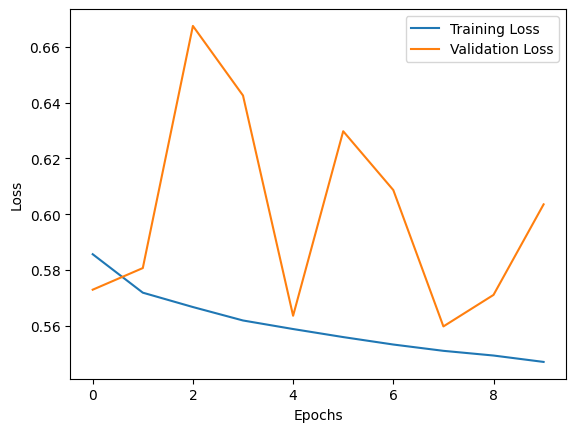

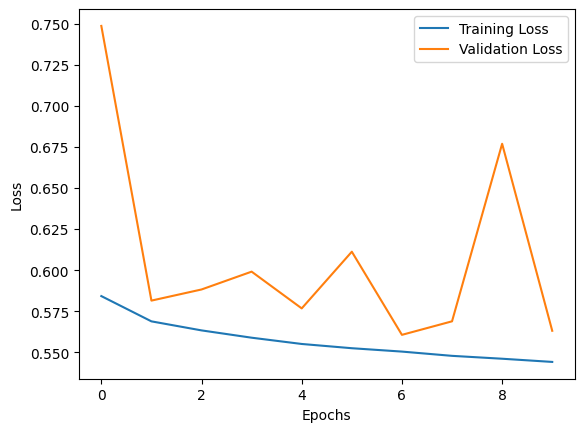

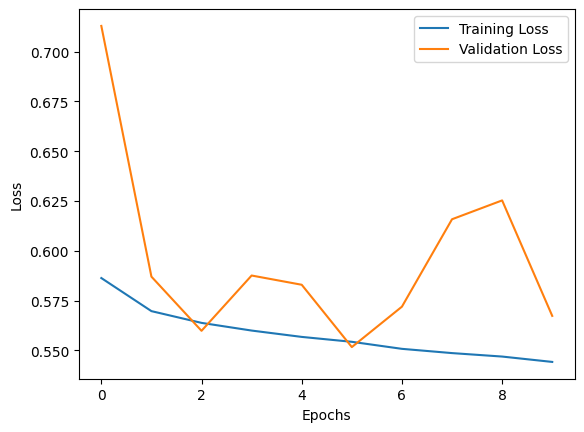

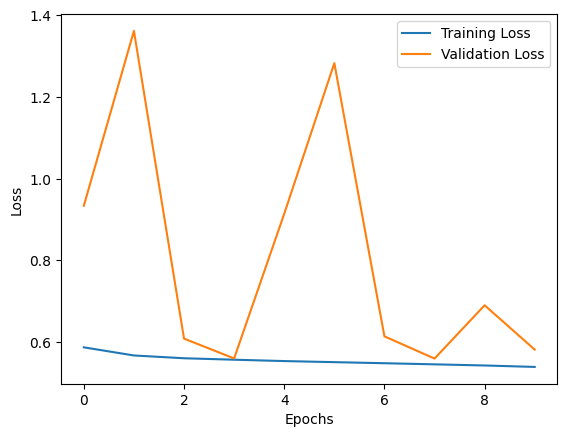

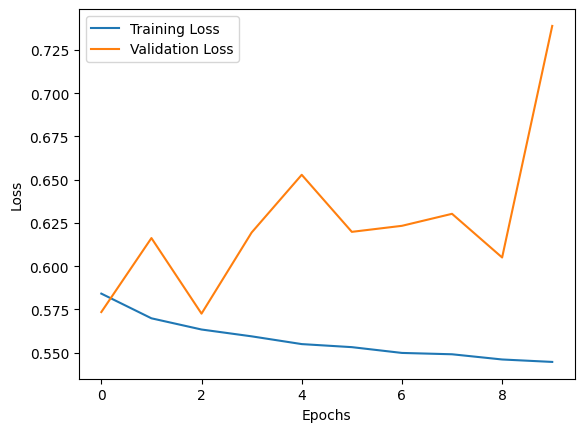

In [16]:
for i in range(5):
    plt.plot(trn_fold_loss[i], label='Training Loss')
    plt.plot(val_fold_loss[i], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()